# Sample Benchmark

Command run:
```bash
docker run -it ubuntu bash -c "\
    sleep 2s; \
    apt-get update; \
    sleep 2s; \
    DEBIAN_FRONTEND=noninteractive apt-get install -y tree stress wget; \
    sleep 2s; \
    tree; \
    sleep 2s; \
    stress --cpu 8 --io 4 --vm 4 --vm-bytes 1024M --timeout 10s; \
    sleep 2s; \
    wget \"http://ipv4.download.thinkbroadband.com/10MB.zip\"; \
    sleep 2s"
```

#### Notes

- Run in a [development environment](https://github.com/moby/moby/blob/master/docs/contributing/set-up-dev-env.md) for moby (docker engine running in container itself)
- Run on a low-end laptop during heavy use (multiple Chromium instances running)
- Designed to stress various aspects, such as I/O, Network, Memory, and CPU (as a synthetic benchmark)

In [14]:
import parser

files = parser.get_all_files("./logs/v1", "log")
data = parser.parse_all(files)

Parsing log data from logs/v1/50ms.log... done


In [15]:
target_file = './logs/v1/50ms.log'
entries = data[target_file]
parser.analyze_timestamps(entries)

min_ts = min(e.read for e in entries.values())

def to_s(nano_ts):
    return float(nano_ts - min_ts) / 1E9

       Read deltas (ms)
count        887.000000
mean          66.368705
std          259.037569
min           51.223877
25%           54.289795
50%           54.785645
75%           55.626221
max         7734.389160


## Timestamp Deltas

The first plot is a histogram, where a logarithmic scale used on both x and y axes. Almost all deltas are closely clustered around 50ms, with a small amount of outliers.

The second plot is a scatterplot of sequential deltas.

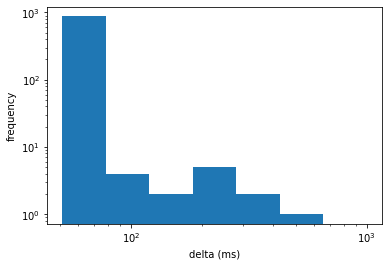

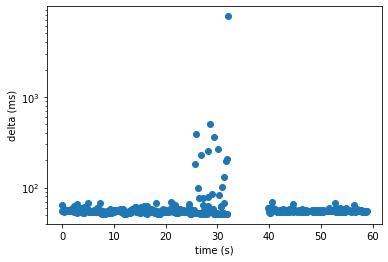

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

d = parser.get_ts_deltas(entries)
deltas = pd.Series(d)
plt.hist(deltas, bins=np.geomspace(deltas.min(), 1000, 8))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("delta (ms)")
plt.ylabel("frequency")
plt.show()

plt.scatter([to_s(e.read) for e in entries.values()][:-1], deltas, marker='o')
plt.yscale('log')
plt.ylabel("delta (ms)")
plt.xlabel("time (s)")
plt.show()

### Period of high deltas

Between timestamp entries 450 and 550, there is a burst of high deltas.

duration of window: 20.927889234s
lagging % of time: 55.06939269627432%


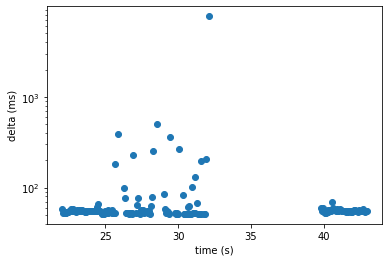

In [17]:
start = 400
end = 600

entries_window = list(entries.values())[start:end]
window = deltas[start:end]

duration = entries_window[-1].read - entries_window[0].read
print(f"duration of window: {float(duration) / 1E9}s")

above_60 = np.sum([d for d in window if d > 60])
total = np.sum(window)
lag_proportion = (above_60 / total) * 100
print(f"lagging % of time: {lag_proportion}%")

time_series_x = [to_s(e.read) for e in entries_window]
plt.scatter(time_series_x, window, marker='o')
plt.yscale('log')
plt.ylabel("delta (ms)")
plt.xlabel("time (s)")
plt.show()


## Future Work

- Run on Cloudlab and create experimental workflow to test:
    1. multiple containers at once
    2. running collectl in the background to test the overhead of the patched engine vs. the non-patched engine
    3. better workload on a bare metal host
- Set `nice` value of the Docker daemon to make it less affected by high workloads
    - This may only be because of the high-intensity synthetic workload imposed
    - This same strategy is used by the `collectl` monitoring step in the current Elba workflow to make instrumentation less affected by system load

## CPU Benchmarks

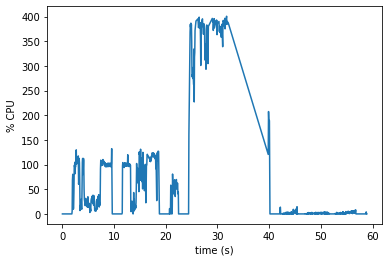

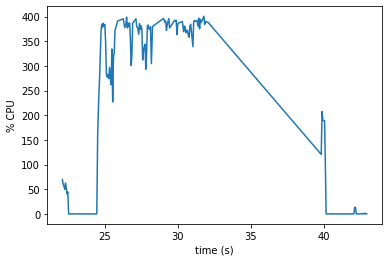

In [18]:
def cpu_per(entry):
    cpu_time = float(entry.cpu.total - entry.pre.cpu.total)
    interval = float(entry.read - entry.pre.read)
    return (cpu_time / interval) * 100

def plot_cpu(entries):
    tail = entries[1:]
    x_series = [to_s(e.read) for e in tail]
    y_series = [cpu_per(e) for e in tail]

    plt.plot(x_series, y_series)
    plt.ylabel("% CPU")
    plt.xlabel("time (s)")
    plt.show()
    
plot_cpu(list(entries.values()))
plot_cpu(entries_window)